### 1.构造10个预测模型

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """

    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    y_col_index = -5  
    y = data.iloc[:, y_col_index].values

    all_columns_except_y = [i for i in range(len(data.columns)) if i!= y_col_index and i!= 0 and i!= 2] # 排除日期列、行业代码列
    input_columns = random.sample(all_columns_except_y, 20)
    x = data.iloc[:, input_columns].values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses, mae, mse, r2


class BiLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.bilstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.relu2(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)


    def forward(self, x):
        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    hidden_size = 50
    num_layers = 2
    output_size = 1
    num_models = 2



    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []
    all_mfd = []


    for model_index in range(num_models):
        all_train_x = []
        all_train_y = []
        all_val_x = []
        all_val_y = []
        all_test_x = []
        all_test_y = []


        file_list = []


        for file in os.listdir(folder_path):
            if file.endswith('.xlsx'):
                file_list.append(file)
                file_path = os.path.join(folder_path, file)
                x_scaled, y_scaled = load_and_preprocess_data(file_path)
                sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
                sequences_x = torch.FloatTensor(sequences_x).to(device)
                sequences_y = torch.FloatTensor(sequences_y).to(device)
                train_size = int(0.7 * len(sequences_x))
                val_size = int(0.2 * len(sequences_x))
                test_size = len(sequences_x) - train_size - val_size
                train_x = sequences_x[:train_size]
                train_y = sequences_y[:train_size]
                val_x = sequences_x[train_size:train_size + val_size]
                val_y = sequences_y[train_size:train_size + val_size]
                test_x = sequences_x[train_size + val_size:]
                test_y = sequences_y[train_size + val_size:]
                all_train_x.append(train_x)
                all_train_y.append(train_y)
                all_val_x.append(val_x)
                all_val_y.append(val_y)
                all_test_x.append(test_x)
                all_test_y.append(test_y)


        train_x = torch.cat(all_train_x, dim=0)
        train_y = torch.cat(all_train_y, dim=0)
        val_x = torch.cat(all_val_x, dim=0)
        val_y = torch.cat(all_val_y, dim=0)
        test_x = torch.cat(all_test_x, dim=0)
        test_y = torch.cat(all_test_y, dim=0)


        train_dataset = TensorDataset(train_x, train_y)
        val_dataset = TensorDataset(val_x, val_y)
        test_dataset = TensorDataset(test_x, test_y)


        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)


        input_size = train_x.shape[2]


        model = BiLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
        train_losses, val_losses, mae, mse, r2 = train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)


        plt.figure(figsize=(10, 5))
        plt.plot(all_train_losses[model_index], label='Training Loss')
        plt.plot(all_val_losses[model_index], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Training and Validation Loss for Model {model_index + 1}')
        plt.show()


        for i, file in enumerate(file_list):
            if i < len(all_mae):
                print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


        model_save_path = f'best_bilstm_attention_gru_cnn_model_20x_{model_index}.pth'
        torch.save(model.state_dict(), model_save_path)
        print(f"模型已存储在 {model_save_path}")



        mfd = 0  
        all_mfd.append(mfd)


    print(f"平均 MFD: {np.mean(all_mfd)}")


if __name__ == "__main__":
    main()

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: nan
Epoch 2/100, Validation Loss: nan
Epoch 3/100, Validation Loss: nan
Epoch 4/100, Validation Loss: nan
Epoch 5/100, Validation Loss: nan
Epoch 6/100, Validation Loss: nan
Epoch 7/100, Validation Loss: nan
Epoch 8/100, Validation Loss: nan
Epoch 9/100, Validation Loss: nan
Epoch 10/100, Validation Loss: nan
Epoch 11/100, Validation Loss: nan
Epoch 12/100, Validation Loss: nan
Epoch 13/100, Validation Loss: nan
Epoch 14/100, Validation Loss: nan
Epoch 15/100, Validation Loss: nan
Epoch 16/100, Validation Loss: nan
Epoch 17/100, Validation Loss: nan
Epoch 18/100, Validation Loss: nan
Epoch 19/100, Validation Loss: nan
Epoch 20/100, Validation Loss: nan
Epoch 21/100, Validation Loss: nan
Epoch 22/100, Validation Loss: nan
Epoch 23/100, Validation Loss: nan
Epoch 24/100, Validation Loss: nan
Epoch 25/100, Validation Loss: nan
Epoch 26/100, Validation Loss: nan
Epoch 27/100, Validation Loss: nan
Epoch 28/100, Validation Loss: nan
Epoch 29/100

KeyboardInterrupt: 

### 2.解决NaN值

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.007221084088087082
Epoch 2/100, Validation Loss: 0.017539380118250847
Epoch 3/100, Validation Loss: 0.006733405054546893
Epoch 4/100, Validation Loss: 0.011960846371948719
Epoch 5/100, Validation Loss: 0.007022907491773367
Epoch 6/100, Validation Loss: 0.015318728052079678
Epoch 7/100, Validation Loss: 0.007671069819480181
Epoch 8/100, Validation Loss: 0.008279700763523579
Epoch 9/100, Validation Loss: 0.01013433001935482
Epoch 10/100, Validation Loss: 0.009053594898432493
Epoch 11/100, Validation Loss: 0.00992258545011282
Epoch 12/100, Validation Loss: 0.008749414701014757
Epoch 13/100, Validation Loss: 0.007324601989239454
Epoch 14/100, Validation Loss: 0.0072081361431628466
Epoch 15/100, Validation Loss: 0.008398815989494324
Epoch 16/100, Validation Loss: 0.008956847712397575
Epoch 17/100, Validation Loss: 0.008910193108022213
Epoch 18/100, Validation Loss: 0.008027501869946718
Epoch 19/100, Validation Loss: 0.009999462403357029
Epoch

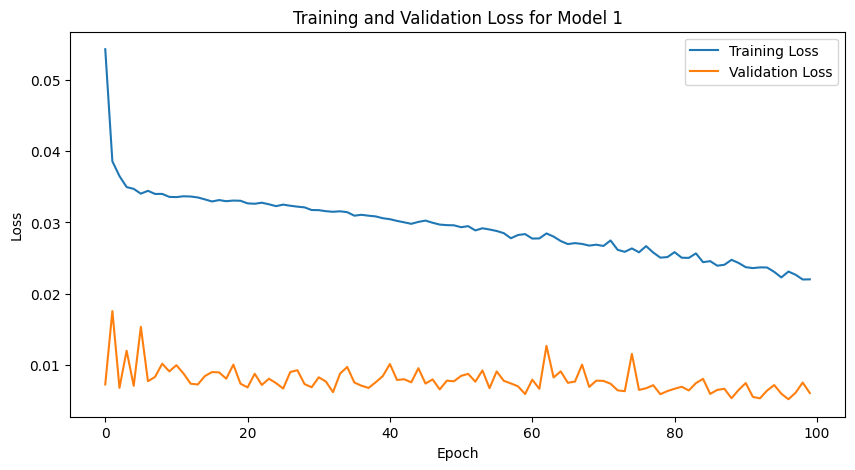

000001.SZ_平安银行_all2.xlsx: MAE=0.08560189604759216, MSE=0.012496081180870533, R2=-0.4851954066238702
模型已存储在 best_bilstm_attention_gru_cnn_model_20x_0.pth
Epoch 1/100, Validation Loss: 0.007919596508145332
Epoch 2/100, Validation Loss: 0.007901192875579
Epoch 3/100, Validation Loss: 0.008676763623952866
Epoch 4/100, Validation Loss: 0.006470839725807309
Epoch 5/100, Validation Loss: 0.007366610458120704
Epoch 6/100, Validation Loss: 0.008652258198708296
Epoch 7/100, Validation Loss: 0.007242681458592415
Epoch 8/100, Validation Loss: 0.008093564305454493
Epoch 9/100, Validation Loss: 0.00935653317719698
Epoch 10/100, Validation Loss: 0.009486299240961671
Epoch 11/100, Validation Loss: 0.009649864165112376
Epoch 12/100, Validation Loss: 0.007855015341192484
Epoch 13/100, Validation Loss: 0.006592568941414356
Epoch 14/100, Validation Loss: 0.00840623420663178
Epoch 15/100, Validation Loss: 0.007310769986361265
Epoch 16/100, Validation Loss: 0.00595248828176409
Epoch 17/100, Validation Loss:

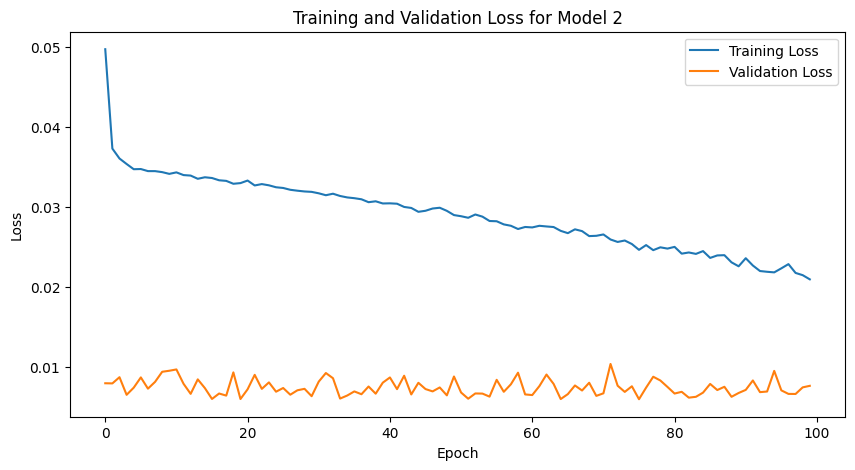

000001.SZ_平安银行_all2.xlsx: MAE=0.08560189604759216, MSE=0.012496081180870533, R2=-0.4851954066238702
000002.SZ_万科A_all2.xlsx: MAE=0.1200082078576088, MSE=0.021288007497787476, R2=-1.53014099526097
模型已存储在 best_bilstm_attention_gru_cnn_model_20x_1.pth
平均 MFD: 0.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    y_col_index = -5  
    y = data.iloc[:, y_col_index].values

    all_columns_except_y = [i for i in range(len(data.columns)) if i!= y_col_index and i!= 0 and i!= 2]  # 排除日期列、行业代码列

    input_columns = random.sample(all_columns_except_y, 20)
    x = data.iloc[:, input_columns].values

    data = pd.DataFrame(x).dropna(axis=0)
    x = data.values

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

                if torch.isnan(outputs).any():
                    print(f"Output contains NaN at epoch {epoch + 1}")
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses, mae, mse, r2


class BiLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMAttentionGRUCNNModel, self).__init__()

        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.bilstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.relu2(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)


    def forward(self, x):
        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    hidden_size = 50
    num_layers = 2
    output_size = 1
    num_models = 2



    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []
    all_mfd = []


    for model_index in range(num_models):
        all_train_x = []
        all_train_y = []
        all_val_x = []
        all_val_y = []
        all_test_x = []
        all_test_y = []


        file_list = []


        for file in os.listdir(folder_path):
            if file.endswith('.xlsx'):
                file_list.append(file)
                file_path = os.path.join(folder_path, file)
                x_scaled, y_scaled = load_and_preprocess_data(file_path)
                sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
                sequences_x = torch.FloatTensor(sequences_x).to(device)
                sequences_y = torch.FloatTensor(sequences_y).to(device)
                train_size = int(0.7 * len(sequences_x))
                val_size = int(0.2 * len(sequences_x))
                test_size = len(sequences_x) - train_size - val_size
                train_x = sequences_x[:train_size]
                train_y = sequences_y[:train_size]
                val_x = sequences_x[train_size:train_size + val_size]
                val_y = sequences_y[train_size:train_size + val_size]
                test_x = sequences_x[train_size + val_size:]
                test_y = sequences_y[train_size + val_size:]
                all_train_x.append(train_x)
                all_train_y.append(train_y)
        all_val_x.append(val_x)
        all_val_y.append(val_y)
        all_test_x.append(test_x)
        all_test_y.append(test_y)


        train_x = torch.cat(all_train_x, dim=0)
        train_y = torch.cat(all_train_y, dim=0)
        val_x = torch.cat(all_val_x, dim=0)
        val_y = torch.cat(all_val_y, dim=0)
        test_x = torch.cat(all_test_x, dim=0)
        test_y = torch.cat(all_test_y, dim=0)


        train_dataset = TensorDataset(train_x, train_y)
        val_dataset = TensorDataset(val_x, val_y)
        test_dataset = TensorDataset(test_x, test_y)


        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)


        input_size = train_x.shape[2]


        model = BiLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
        train_losses, val_losses, mae, mse, r2 = train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)


        plt.figure(figsize=(10, 5))
        plt.plot(all_train_losses[model_index], label='Training Loss')
        plt.plot(all_val_losses[model_index], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Training and Validation Loss for Model {model_index + 1}')
        plt.show()


        for i, file in enumerate(file_list):
            if i < len(all_mae):
                print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


        model_save_path = f'best_bilstm_attention_gru_cnn_model_20x_{model_index}.pth'
        torch.save(model.state_dict(), model_save_path)
        print(f"模型已存储在 {model_save_path}")



        mfd = 0  
        all_mfd.append(mfd)


    print(f"平均 MFD: {np.mean(all_mfd)}")


if __name__ == "__main__":
    main()

### 3.记录随机抽取的20个x特征列名信息，方便后续预测

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.008398938924074173
Epoch 2/100, Validation Loss: 0.010654589394107461
Epoch 3/100, Validation Loss: 0.00728061213158071
Epoch 4/100, Validation Loss: 0.006958540994673967
Epoch 5/100, Validation Loss: 0.00855870870873332
Epoch 6/100, Validation Loss: 0.010428058914840221
Epoch 7/100, Validation Loss: 0.007309977663680911
Epoch 8/100, Validation Loss: 0.008681807667016983
Epoch 9/100, Validation Loss: 0.007962984032928944
Epoch 10/100, Validation Loss: 0.009192582685500383
Epoch 11/100, Validation Loss: 0.00694112223573029
Epoch 12/100, Validation Loss: 0.007014173083007336
Epoch 13/100, Validation Loss: 0.007598383468575776
Epoch 14/100, Validation Loss: 0.007017094874754548
Epoch 15/100, Validation Loss: 0.00807190197519958
Epoch 16/100, Validation Loss: 0.007260482991114259
Epoch 17/100, Validation Loss: 0.010516931302845478
Epoch 18/100, Validation Loss: 0.007225061766803265
Epoch 19/100, Validation Loss: 0.0068486088421195745
Epoch 2

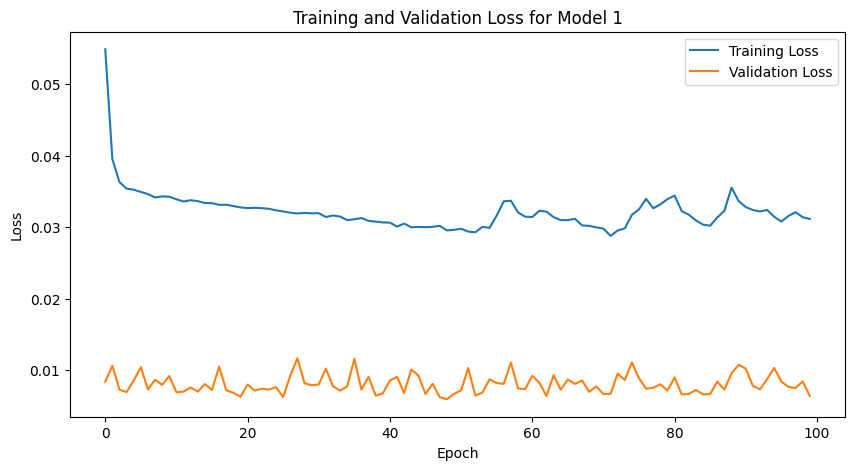

000001.SZ_平安银行_all2.xlsx: MAE=0.07008697837591171, MSE=0.009472998790442944, R2=-0.12589318335973987
模型已存储在 best_bilstm_attention_gru_cnn_model_20x_0.pth
Epoch 1/100, Validation Loss: 0.007272493094205856
Epoch 2/100, Validation Loss: 0.0090305102057755
Epoch 3/100, Validation Loss: 0.00857792911119759
Epoch 4/100, Validation Loss: 0.010761901270598173
Epoch 5/100, Validation Loss: 0.00842213467694819
Epoch 6/100, Validation Loss: 0.00954138208180666
Epoch 7/100, Validation Loss: 0.00855846144258976
Epoch 8/100, Validation Loss: 0.011688913218677044
Epoch 9/100, Validation Loss: 0.013905844185501337
Epoch 10/100, Validation Loss: 0.0083547483664006
Epoch 11/100, Validation Loss: 0.009279431309551
Epoch 12/100, Validation Loss: 0.008062106557190418
Epoch 13/100, Validation Loss: 0.007851850241422653
Epoch 14/100, Validation Loss: 0.007645865902304649
Epoch 15/100, Validation Loss: 0.007213368779048324
Epoch 16/100, Validation Loss: 0.007784794084727764
Epoch 17/100, Validation Loss: 0.0

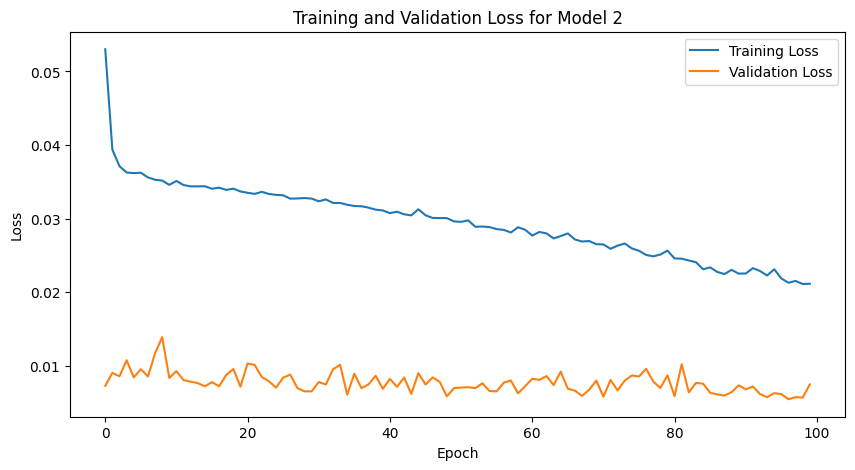

000001.SZ_平安银行_all2.xlsx: MAE=0.07008697837591171, MSE=0.009472998790442944, R2=-0.12589318335973987
000002.SZ_万科A_all2.xlsx: MAE=0.08342842012643814, MSE=0.011518259532749653, R2=-0.36897839745102634
模型已存储在 best_bilstm_attention_gru_cnn_model_20x_1.pth
平均 MFD: 0.0
Selected columns for each model:
Model 1: [6, 3, 26, 60, 34, 20, 49, 13, 61, 50, 37, 48, 23, 51, 45, 42, 11, 40, 68, 12]
Model 2: [40, 61, 42, 50, 68, 57, 11, 70, 19, 15, 72, 7, 18, 21, 44, 69, 5, 33, 66, 32]
Model 3: [61, 67, 17, 40, 37, 68, 60, 15, 28, 7, 34, 45, 58, 52, 18, 16, 53, 35, 70, 50]
Model 4: [4, 54, 53, 33, 3, 64, 50, 58, 46, 65, 40, 55, 51, 17, 26, 62, 67, 43, 52, 12]
Model 5: [23, 19, 65, 20, 67, 16, 27, 36, 39, 7, 8, 40, 12, 69, 21, 25, 32, 52, 63, 31]
Model 6: [6, 27, 64, 28, 11, 20, 43, 30, 60, 12, 7, 4, 34, 14, 23, 63, 58, 42, 51, 31]
Model 7: [7, 44, 49, 70, 68, 46, 66, 36, 45, 59, 37, 50, 13, 38, 1, 32, 23, 72, 41, 51]
Model 8: [32, 39, 62, 52, 25, 57, 9, 18, 71, 43, 55, 7, 36, 45, 54, 28, 4, 31, 46, 42

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """

    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    y_col_index = -5 
    y = data.iloc[:, y_col_index].values

    all_columns_except_y = [i for i in range(len(data.columns)) if i!= y_col_index and i!= 0 and i!= 2]  # 排除日期列、行业代码列
    input_columns = random.sample(all_columns_except_y, 20)
    x = data.iloc[:, input_columns].values
    data = pd.DataFrame(x).dropna(axis=0)
    x = data.values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled, input_columns


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
                if torch.isnan(outputs).any():
                    print(f"Output contains NaN at epoch {epoch + 1}")
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses, mae, mse, r2


class BiLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.bilstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.relu2(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)


    def forward(self, x):
        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    hidden_size = 50
    num_layers = 2
    output_size = 1
    num_models = 2



    if torch.cuda.is_available():
        device = torch.device("cuda:0") 
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []
    all_mfd = []
    all_selected_columns = [] 


    for model_index in range(num_models):
        all_train_x = []
        all_train_y = []
        all_val_x = []
        all_val_y = []
        all_test_x = []
        all_test_y = []


        file_list = []


        for file in os.listdir(folder_path):
            if file.endswith('.xlsx'):
                file_list.append(file)
                file_path = os.path.join(folder_path, file)
                x_scaled, y_scaled, selected_columns = load_and_preprocess_data(file_path)
                all_selected_columns.append(selected_columns)  # 存储选择的列
                sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
                sequences_x = torch.FloatTensor(sequences_x).to(device)
                sequences_y = torch.FloatTensor(sequences_y).to(device)
                train_size = int(0.7 * len(sequences_x))
                val_size = int(0.2 * len(sequences_x))
                test_size = len(sequences_x) - train_size - val_size
                train_x = sequences_x[:train_size]
                train_y = sequences_y[:train_size]
                val_x = sequences_x[train_size:train_size + val_size]
                val_y = sequences_y[train_size:train_size + val_size]
                test_x = sequences_x[train_size + val_size:]
                test_y = sequences_y[train_size + val_size:]
                all_train_x.append(train_x)
                all_train_y.append(train_y)
        all_val_x.append(val_x)
        all_val_y.append(val_y)
        all_test_x.append(test_x)
        all_test_y.append(test_y)


        train_x = torch.cat(all_train_x, dim=0)
        train_y = torch.cat(all_train_y, dim=0)
        val_x = torch.cat(all_val_x, dim=0)
        val_y = torch.cat(all_val_y, dim=0)
        test_x = torch.cat(all_test_x, dim=0)
        test_y = torch.cat(all_test_y, dim=0)


        train_dataset = TensorDataset(train_x, train_y)
        val_dataset = TensorDataset(val_x, val_y)
        test_dataset = TensorDataset(test_x, test_y)


        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)


        input_size = train_x.shape[2]


        model = BiLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
        train_losses, val_losses, mae, mse, r2 = train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)


        plt.figure(figsize=(10, 5))
        plt.plot(all_train_losses[model_index], label='Training Loss')
        plt.plot(all_val_losses[model_index], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Training and Validation Loss for Model {model_index + 1}')
        plt.show()


        for i, file in enumerate(file_list):
            if i < len(all_mae):
                print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


        model_save_path = f'best_bilstm_attention_gru_cnn_model_20x_{model_index}.pth'
        torch.save(model.state_dict(), model_save_path)
        print(f"模型已存储在 {model_save_path}")


        mfd = 0  
        all_mfd.append(mfd)


    print(f"平均 MFD: {np.mean(all_mfd)}")
    print("Selected columns for each model:")
    for i, columns in enumerate(all_selected_columns):
        print(f"Model {i + 1}: {columns}")


if __name__ == "__main__":
    main()

### 4.读取指定列进行推理预测，并返回模型-公司-预测值/真实值对象

GPU 可用，使用 GPU 加速


e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38134 (\N{CJK UNIFIED IDEOGRAPH-94F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


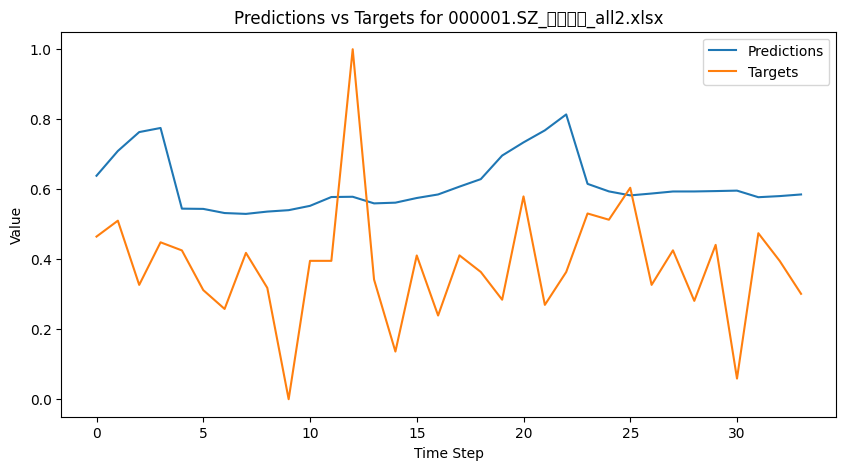

e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


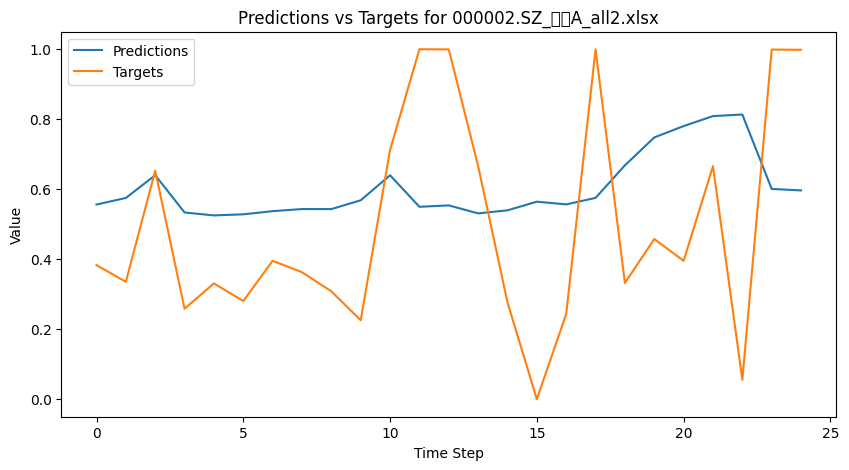

e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20852 (\N{CJK UNIFIED IDEOGRAPH-5174}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35759 (\N{CJK UNIFIED IDEOGRAPH-8BAF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


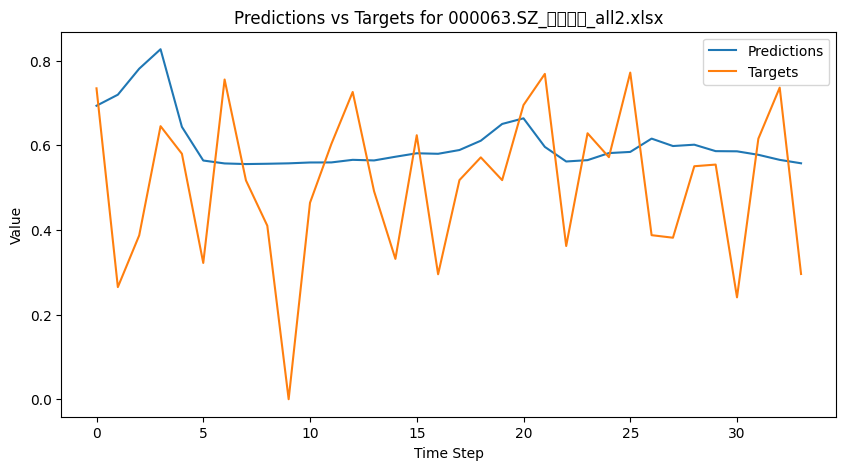

e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25216 (\N{CJK UNIFIED IDEOGRAPH-6280}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


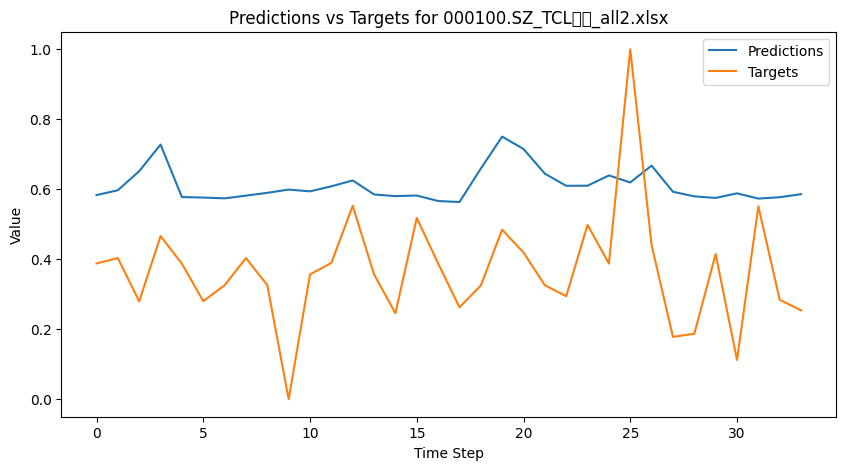

e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32852 (\N{CJK UNIFIED IDEOGRAPH-8054}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Anaconda\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


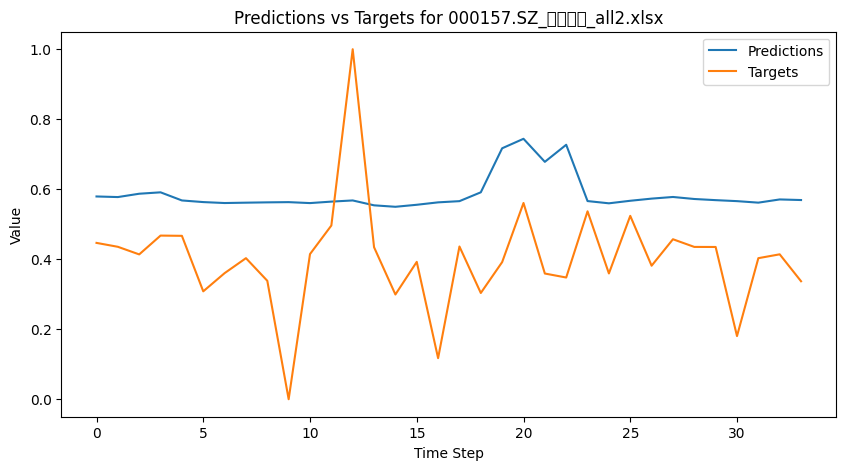

IndexError: positional indexers are out-of-bounds

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path, temp):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :param temp: 列索引列表
    :return: 预处理后的序列数据
    """

    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[200:, 1:]
    y_col_index = -5  
    y = data.iloc[:, y_col_index].values

    x = data.iloc[:, temp].values
    data = pd.DataFrame(x).dropna(axis=0)
    x = data.values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def predict_with_model(model, test_loader, device):
    """
    使用模型进行预测
    :param model: 已训练好的模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 预测结果列表，真实结果列表
    """
    model.eval()
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    return test_predictions, test_targets


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    hidden_size = 50
    num_layers = 2
    output_size = 1
    temp = [6, 3, 26, 60, 34, 20, 49, 13, 61, 50, 37, 48, 23, 51, 45, 42, 11, 40, 68, 12]  # 替换为你实际的列索引列表



    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_company_predictions = {}
    all_company_targets = {}


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path, temp)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)


            test_dataset = TensorDataset(sequences_x, sequences_y)
            test_loader = DataLoader(test_dataset, batch_size=32)


            input_size = sequences_x.shape[2]


            model_path = f'best_bilstm_attention_gru_cnn_model_20x_0.pth'  
            model = BiLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
            model.load_state_dict(torch.load(model_path))


            predictions, targets = predict_with_model(model, test_loader, device)


            all_company_predictions[file] = predictions
            all_company_targets[file] = targets


            plt.figure(figsize=(10, 5))
            plt.plot(predictions, label='Predictions')
            plt.plot(targets, label='Targets')
            plt.xlabel('Time Step')
            plt.ylabel('Value')
            plt.legend()
            plt.title(f'Predictions vs Targets for {file}')
            plt.show()


    import pickle
    with open('company_predictions.pkl', 'wb') as f:
        pickle.dump((all_company_predictions, all_company_targets), f)


class BiLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.bilstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.relu2(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)


    def forward(self, x):
        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


if __name__ == "__main__":
    main()